In [1]:
import networkx as nx
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [2]:
#create a pandas dataframes from csv files
inputs = pd.read_csv('inputs.csv', header=None)
inputs.columns = ['id', 'tx_id', 'sig_id', 'output_id']

outputs = pd.read_csv('outputs.csv', header=None)
outputs.columns = ['id', 'tx_id', 'pk_id', 'value']

transactions = pd.read_csv('transactions.csv', header=None)
transactions.columns = ['id', 'block_id']

In [3]:
def drop_invalid_transactions(tx_ids, inputs, outputs, transactions):
    for tx_id in tx_ids:
        inputs = inputs.drop(inputs[inputs['tx_id'] == tx_id].index)
        outputs = outputs.drop(outputs[outputs['tx_id'] == tx_id].index)
        transactions = transactions.drop(transactions[transactions['id'] == tx_id].index)
    return inputs, outputs, transactions

In [4]:
localUTXO = []
spentUTXO = []
invalid_transaction = []
backup = 1

if backup == 0:
    for index, transaction in transactions.iterrows():
        #take all the input of the selected transaction
        tx_input = inputs[inputs['tx_id'] == transaction['id']]
        count_input = 0
        remove_UTXO = []
        invalid = 0

        #check if the input are ok
        for index, inp in tx_input.iterrows():
            key_input = inp['output_id']
            #case in which isn't a coinbase transaction
            if key_input != -1:
                old_outputs = outputs[outputs['id'] == key_input]

                if old_outputs.empty:
                    invalid = 1
                    invalid_transaction.append(transaction['id'])
                    print("TX" + str(transaction['id']) + ": No TX Input found!")

                for index, old_output in old_outputs.iterrows():
                    #double spending in the same transaction checks
                    if old_output['id'] in remove_UTXO or old_output['id'] in spentUTXO:
                        invalid = 1
                        invalid_transaction.append(transaction['id'])
                        print("TX" + str(transaction['id']) + ": UTXO " + str(old_output['id']) + " double spending!")

                    elif old_output['id'] not in localUTXO:
                        invalid = 1
                        invalid_transaction.append(transaction['id'])
                        print("TX" + str(transaction['id']) + ": UTXO " + str(old_output['id']) + " missing!")

                    remove_UTXO.append(old_output['id'])
                    count_input = count_input + old_output['value']

        tx_output = outputs[outputs['tx_id'] == transaction['id']]
        count_output = 0;
        add_UTXO = []

        if tx_output.empty:
            invalid = 1
            invalid_transaction.append(transaction['id'])
            print("TX" + str(transaction['id']) + ": No TX Output found!")

        for index, output in tx_output.iterrows():
            count_output = count_output + output['value']

            add_UTXO.append(output['id'])


        if(count_input < count_output and count_input != 0 and count_output != 0):
            print("TX" + str(transaction['id']) + ": Output value " + str(count_output) + \
                  " bigger than input value " + str(count_input) + "!")
            invalid = 1;
            invalid_transaction.append(transaction['id'])

        if invalid == 0:
            for item in add_UTXO:
                localUTXO.append(item)
            for item in remove_UTXO:
                spentUTXO.append(item)
                localUTXO.remove(item)

    print("Removing invalid data transactions...")
invalid_trasactions = [12152, 15698, 30446, 61845, 100929, 137237, 204751]
inputs, outputs, transactions = drop_invalid_transactions(invalid_transaction, inputs, outputs, transactions)


In [5]:
#TODO: computare tutti gli UTXO
max_UTXO = {'tx_id' : -1, 'block_id' : -1, 'output_id' : -1, 'value' : -1, 'address' : -1}

transactions.columns = ['tx_id', 'block_id']
total_amount = 0
tx_outputs = outputs.join(transactions.set_index('tx_id'), on='tx_id')
for UTXO in localUTXO:
    UTXO_df = tx_outputs[tx_outputs['id'] == UTXO]
    for index, out in UTXO_df.iterrows():
        total_amount = total_amount + int(out['value'])
        if(max_UTXO['value'] < int(out['value'])):
            max_UTXO['tx_id'] = out['tx_id']
            max_UTXO['block_id'] = out['block_id']
            max_UTXO['output_id'] = out['id']
            max_UTXO['value'] = out['value']
            max_UTXO['address'] = out['pk_id']
            print("New max found: UTXO " + str(out['id']))
            
#count how much UTXOs there are in the last block
print("Total UTXO: " + str(len(localUTXO)))
print("Total spent TXO: " + str(len(spentUTXO)))
print("TOTAL TRANSACTION OUTPUT: " + str(len(spentUTXO) + len(localUTXO)))
print("**************************************")
print("TOTAL UNSPENT VALUE : " + str(total_amount))

Total UTXO: 0
Total spent TXO: 0
TOTAL TRANSACTION OUTPUT: 0
**************************************
TOTAL UNSPENT VALUE : 0


In [6]:
#print the UTXO with maximum value
print('*************\nMAXIMUM UTXO\n*************' + \
      '\nTX_ID: ' + str(max_UTXO['tx_id']) + \
      '\nBLOCK_ID: ' + str(max_UTXO['block_id']) + \
      '\nOUTPUT_ID: ' + str(max_UTXO['output_id']) + \
      '\nVALUE: ' + str(max_UTXO['value']) + \
      '\nADDRESS: ' + str(max_UTXO['address']))

*************
MAXIMUM UTXO
*************
TX_ID: -1
BLOCK_ID: -1
OUTPUT_ID: -1
VALUE: -1
ADDRESS: -1


In [7]:
#calculate the period of time of each tx
month = []
aa = transactions
for index, block in aa.iterrows():
    month.append(int(block['block_id']/4320) + 1)
aa['month'] = month

a = aa[['id', 'block_id']].groupby('block_id').count()
a.columns = ['number_tx']

a.plot(kind='line')

print(a.columns)

b = aa[['month', 'id']].groupby('month').count().astype(int)
b.columns = ['block_size']
block_size = []
for index, block in b.iterrows():
    block_size.append(block['block_size']/4320)
b['block_size'] = block_size
b.plot(kind='line')

/var/folders/jf/2klxw_5j40b99lw0dpk1tt5w0000gn/T/ipykernel_18629/864223411.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  pk_value = tmp.join(inputs_value)


<AxesSubplot:xlabel='pk_id'>

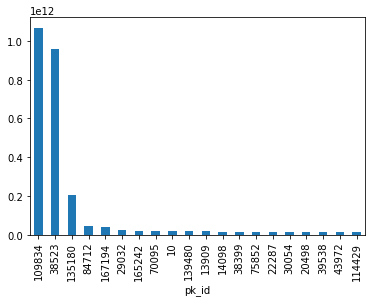

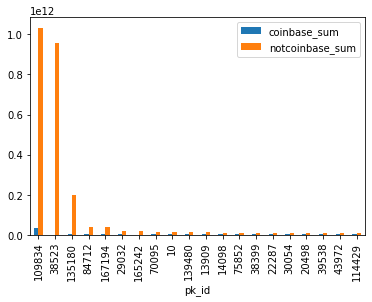

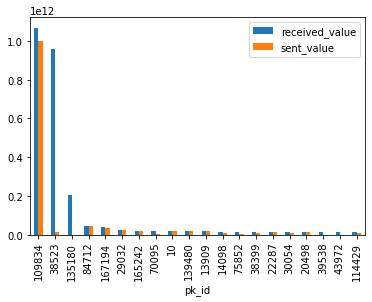

In [18]:
#get the list of COINBASE TX
coinbase_tx = inputs[inputs['sig_id'] == 0]['tx_id'].tolist()

#get the list of the public keys that have at least one COINBASE TX
coinbase_pk = outputs[outputs['tx_id'].isin(coinbase_tx)]['pk_id'].tolist()

#get for each public key the amount of value received
pk_value = outputs[outputs['pk_id'].isin(coinbase_pk)].groupby(by=['pk_id'])['value'].agg(['sum','count'])
pk_value = pk_value.sort_values(by = ['sum', 'count'], ascending=[False, True])
pk_value['sum'].head(20).plot(kind = 'bar', use_index=True)


#calculate for each address miners how much have earned from coinbase transactions
#get a
coinbase = outputs[outputs['tx_id'].isin(coinbase_tx)].groupby(by=['pk_id'])['value'].agg(['sum','count'])
coinbase = coinbase.sort_values(by = ['sum','count'], ascending=[False, False])

pk_value.columns = ['total_sum', 'count_tot']
coinbase.columns = ['coinbase_sum', 'count_cb']
pk_value = coinbase.join(pk_value)

pk_value['count_ncb'] = pk_value['count_tot'] - pk_value['count_cb']
pk_value['notcoinbase_sum'] = pk_value['total_sum'] - pk_value['coinbase_sum']

pk_value = pk_value.sort_values(by = ['total_sum'], ascending=[False])
pk_value.columns = ['coinbase_sum', 'count_cb', 'total_sum', 'count_tot', 'count_ncb', 'notcoinbase_sum']
pk_value[['coinbase_sum', 'notcoinbase_sum']].head(20).plot(kind = 'bar', use_index=True)

#count how much transaction came from miner's address
transactions.columns = ['tx_id', 'block_id', 'month']

inputs_miner = inputs[inputs['sig_id'].isin(coinbase_pk)]['output_id'].tolist()
inputs_value = outputs[outputs['id'].isin(inputs_miner)][['pk_id','value']].groupby('pk_id').agg(['sum'])
tmp = pk_value[['total_sum']]
pk_value = tmp.join(inputs_value)
pk_value.columns = ['received_value', 'sent_value']
pk_value.head(20).plot(kind = 'bar', use_index=True)

In [10]:
#select all the transactions that aren't a coinbase
tx = inputs[inputs['output_id'] != -1]['tx_id'].drop_duplicates()
tx_fees = tx.tolist()
fees = []

for transaction in tx_fees:
    input_list = inputs[inputs['tx_id'] == transaction]['output_id'].tolist()
    input_value = outputs[outputs['id'].isin(input_list)]['value'].tolist()
    output_value = outputs[outputs['tx_id'] == transaction]['value'].tolist()
    fees.append(int(sum(input_value) - sum(output_value)))

tx = tx.to_frame()
tx['fees'] = fees
tx = transactions.merge(tx, on='tx_id', how='left')

<AxesSubplot:xlabel='month'>

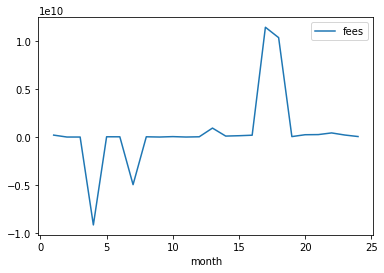

In [11]:
txs = tx[['month', 'fees']]
txs = txs.groupby('month')['fees'].agg(['sum'])
txs.columns = ['fees']

txs.plot(kind='line')

         tx_id  block_id  month          fees
105280  105281     75047     18  1.000000e+10
92975    92976     70509     17  4.999971e+09
100848  100849     72855     17  4.999971e+09
101661  101662     73272     17  4.320000e+08
60912    60913     55819     13  3.350000e+08
60910    60911     55819     13  2.730000e+08
60971    60972     55869     13  2.640000e+08
100683  100684     72763     17  2.310000e+08
137236  137237     88755     21  1.666667e+08
104984  104985     74939     18  1.550000e+08
92434    92435     70209     17  1.520000e+08
71417    71418     63531     15  1.370000e+08
93038    93039     70537     17  1.180000e+08
92437    92438     70210     17  1.070000e+08
121712  121713     82672     20  1.030000e+08
2863      2864      2817      1  1.000000e+08
2862      2863      2817      1  1.000000e+08
62445    62446     57052     14  9.900000e+07
94902    94903     70880     17  9.500000e+07
97309    97310     71052     17  8.900000e+07
140483  140484     90535     21  8

<AxesSubplot:>

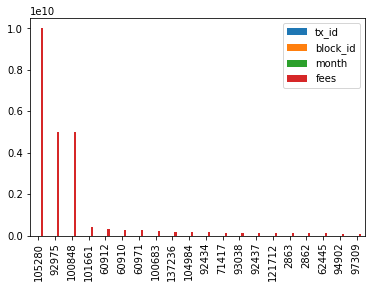

In [20]:
print(tx.sort_values(by = ['fees'], ascending=[False]).head(50))
tx.sort_values(by = ['fees'], ascending=[False]).head(20).plot(kind='bar')

In [13]:
print(outputs[outputs['value'] < 0])

            id   tx_id   pk_id       value
123671  123672  105281  155098 -5000000000


In [14]:
print(outputs[outputs['tx_id'] == 92976])
print(inputs[inputs['tx_id'] == 92976])
print(outputs[outputs['id'] == 108290])

            id  tx_id  pk_id  value
108615  108616  92976  92934  29000
            id  tx_id  sig_id  output_id
120377  120378  92976   92696     108290
            id  tx_id  pk_id       value
108289  108290  92707  92696  5000000000


In [15]:
print(outputs[outputs['tx_id'] == 100844])
print(inputs[inputs['tx_id'] == 100844])
print(outputs[outputs['id'] == 117654])

            id   tx_id  pk_id       value
118018  118019  100844  98030  5000000000
            id   tx_id  sig_id  output_id
132087  132088  100844   97734     117654
            id   tx_id  pk_id       value
117653  117654  100554  97734  5000000000


Index(['number_tx'], dtype='object')


<AxesSubplot:xlabel='month'>

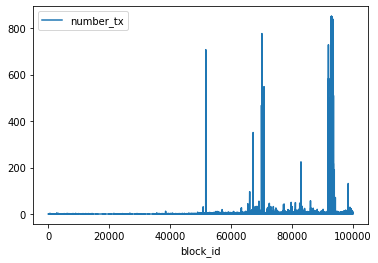

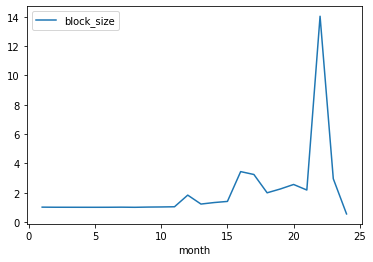

In [28]:
transactions = pd.read_csv('transactions.csv', header=None)
transactions.columns = ['id', 'block_id']

inputs, outputs, transactions = drop_invalid_transactions(invalid_transaction, inputs, outputs, transactions)
#calculate the period of time of each tx
month = []
aa = transactions
for index, block in aa.iterrows():
    month.append(int(block['block_id']/4320) + 1)
aa['month'] = month

a = aa[['id', 'block_id']].groupby('block_id').count()
a.columns = ['number_tx']

a.plot(kind='line')

print(a.columns)

b = aa[['month', 'id']].groupby('month').count().astype(int)
b.columns = ['block_size']
block_size = []
for index, block in b.iterrows():
    block_size.append(block['block_size']/4320)
b['block_size'] = block_size
b.plot(kind='line')
